In [183]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [184]:
df = pd.read_csv('data/processed.csv', index_col='Date')
features = ['MA_5', 'MA_20', 'MACD', 'RSI', 'OBV', 'ATR', 'fng', 'Upper_BB', 'Middle_BB', 'Lower_BB']
X = df[features].dropna()
y = df['Close'].loc[X.index]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    
# # Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=10)  # Select top 10 features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

In [185]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(RandomForestRegressor(n_jobs=-1), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

# best_model = RandomForestRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=2, max_features='sqrt',max_depth=10)
# best_model.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", -grid_search.best_score_)  # Negating because of neg_mean_squared_error
print("Test set R-squared score:", best_model.score(X_test_scaled, y_test))

Best parameters: {'max_features': 'sqrt', 'min_samples_leaf': 1}
Best cross-validation score: 33.61022342402991
Test set R-squared score: 0.17767000564365654


In [186]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = best_model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 10.497012839635213, RMSE: 17.023545412938944


In [187]:
predictions = best_model.predict(X_test_scaled);

preds = pd.DataFrame(y_test)
preds['Prediction'] = predictions

print(preds)

                 Close  Prediction
Date                              
2023-09-21  173.929993  175.442401
2023-09-22  174.789993  175.410001
2023-09-25  176.080002  176.033901
2023-09-26  171.960007  174.579101
2023-09-27  170.429993  174.432600
...                ...         ...
2024-08-28  226.490005  188.209802
2024-08-29  229.789993  189.027901
2024-08-30  229.000000  188.658702
2024-09-03  222.770004  185.772302
2024-09-04  220.850006  185.042902

[240 rows x 2 columns]


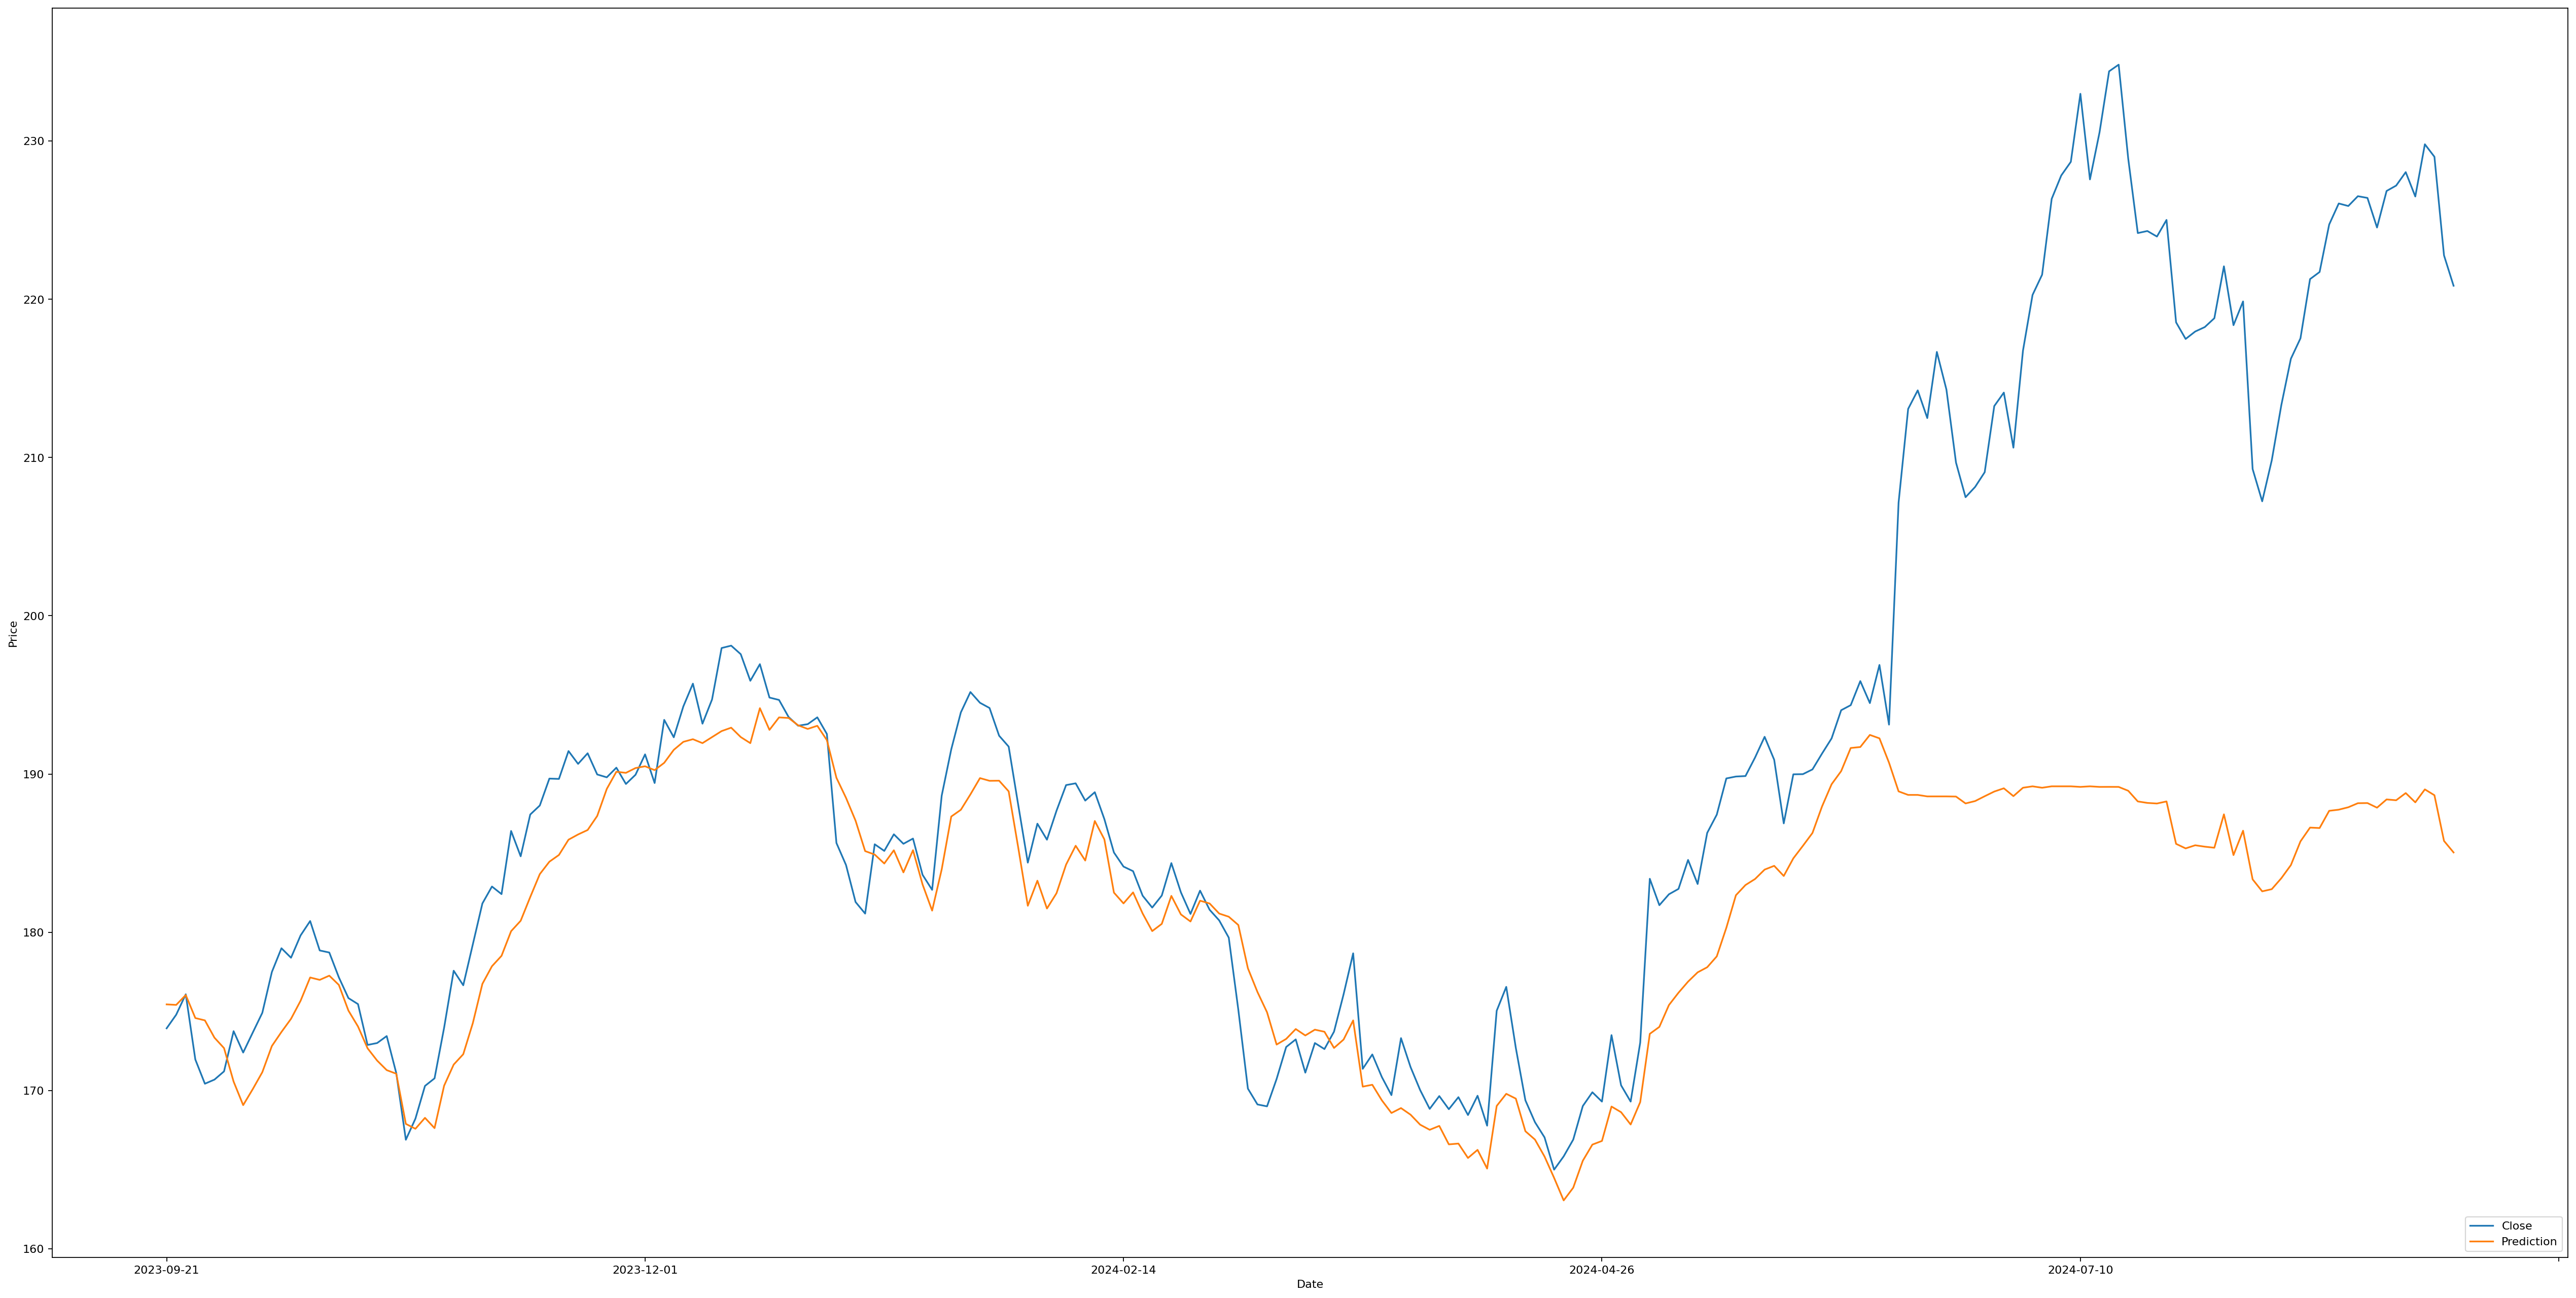

In [188]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
figure(num=None, figsize=(40, 20), dpi=160, facecolor='w', edgecolor='k')
preds['Close'].plot()
preds['Prediction'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()